# Exploratory Analysis

This notebook contains all steps performed in the exploratory analysis phase of the pipeline and all insights gained.

___

## The Required Imports

Below are all the modules needed to run the code cells in this notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [49]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import nltk
from wordcloud import WordCloud

from prepare import words_explore, words
from preprocessing import split_data

___

## Acquire and Prepare the Data

Now we will acquire and prepare the data that we'll be using throughout this notebook.

In [3]:
# First we acquire the data by reading the data.json file.
df = pd.read_json('data.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             100 non-null    object
 1   language         96 non-null     object
 2   readme_contents  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [4]:
# Now we prepare it using the words function from the prepare module
df = words_explore(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   repo        100 non-null    object
 1   language    100 non-null    object
 2   readme      100 non-null    object
 3   clean       100 non-null    object
 4   stemmed     100 non-null    object
 5   lemmatized  100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB


___

## Split the Data

Now we will split the data into three datasets: train, validate, and test. The train set will be the one we explore in this notebook and the one used for training machine learning models. Validate and test will serve as unseen data in the modeling phase of the pipeline.

In [5]:
# Here we will split the data using the split_data function from the preprocessing module.
train, validate, test = split_data(df, stratify = 'language')
train.shape, validate.shape, test.shape

((56, 6), (24, 6), (20, 6))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 11 to 7
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   repo        56 non-null     object
 1   language    56 non-null     object
 2   readme      56 non-null     object
 3   clean       56 non-null     object
 4   stemmed     56 non-null     object
 5   lemmatized  56 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB


For the rest of this notebook we'll only be using the train dataset.

___

## Univariate Analysis

In this section we'll be focusing on exploring only single variables in the data.

### Exploring the Target Variable

Let's see how the target variable is distributed. This will help us determine if there are imbalances in the data and possibly will help us determine the ideal performance metric to use in modeling. This will also let us know what values we are trying to predict.

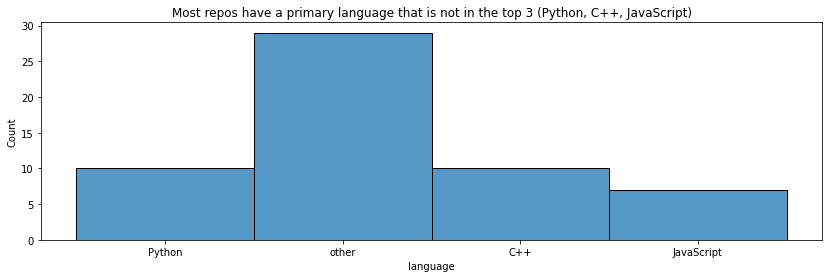

In [7]:
# Plot histogram of the target variable

plt.figure(figsize = (14, 4))
sns.histplot(data = train, x = 'language')
plt.title('Most repos have a primary language that is not in the top 3 (Python, C++, JavaScript)');

**Takeaways:**
- The distribution among the top 3 programming languages (Python, C++, and JavaScript) is fairly uniform. Most target languages are some other language though.
- Accuracy could be a good metric to use, but if accuracy proves to be an untrustworthy metric focusing on the top 3 languages might be preferable.
- There is some imbalance in the target variable, but we would need more data to determine if the imbalance is truly a problem.

### Word Frequencies in Clean Text

Let's look at the most frequent words in the cleaned version of the READMEs.

In [8]:
# Join all readmes into one string

clean_words = ' '.join(readme for readme in df.clean)

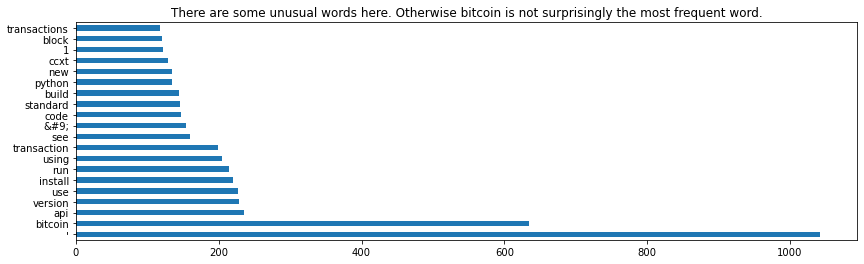

In [9]:
# Plot top 20 words

plt.figure(figsize = (14, 4))
clean_words_freq = pd.Series(clean_words.split())
clean_words_freq.value_counts().head(20).plot.barh()
plt.title('There are some unusual words here. Otherwise bitcoin is not surprisingly the most frequent word.');

**Takeaways:**
- There are a few unusual words in the top 20 (', &#9;, l). We'll have to see if these show up throughout the notebook and if they do we'll need to update the prepare script to exclude these.
- We do see python mentioned frequently. This could be helpful especially if python is mentioned in repos where python is the primary language.

### Word Frequencies in Stemmed

Now let's look at the word frequencies in the stemmed version of the READMEs.

In [10]:
# Join all readmes into one string

stemmed_words = ' '.join(readme for readme in df.stemmed)

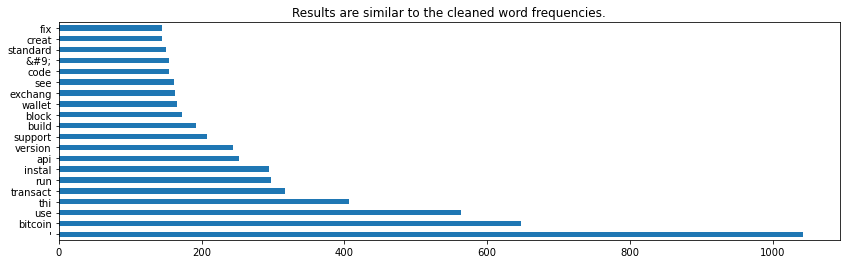

In [11]:
# Plot top 20 words

plt.figure(figsize = (14, 4))
stemmed_words_freq = pd.Series(stemmed_words.split())
stemmed_words_freq.value_counts().head(20).plot.barh()
plt.title('Results are similar to the cleaned word frequencies.');

**Takeaways:**
- Not much new takeaways here.

### Word Frequencies in Lemmatized

Finally, let's look at the word frequencies in the lemmatized versions of the READMEs.

In [12]:
# Join all readmes into one string

lemmatized_words = ' '.join(readme for readme in df.lemmatized)

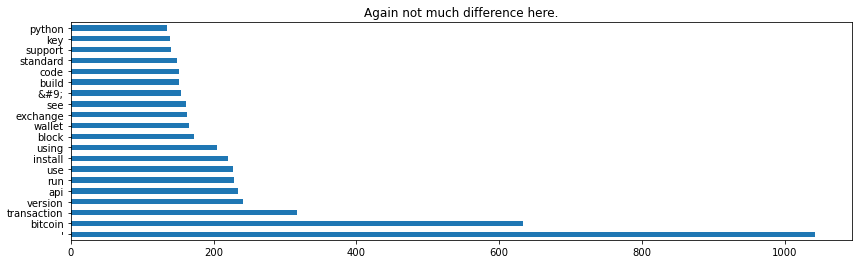

In [13]:
# Plot top 20 words

plt.figure(figsize = (14, 4))
lemmatized_words_freq = pd.Series(lemmatized_words.split())
lemmatized_words_freq.value_counts().head(20).plot.barh()
plt.title('Again not much difference here.');

**Takeaways:**
- Similar results as before.

### Takeaways

There are some words that we may need to add to the exclude_words list for removing stopwords since they don't provide much value to us. Otherwise, a lot of the most common words are fairly general such as bitcoin, version, api, etc. We'll need to see how these word frequencies vary between each target class.

___

## Bivariate Analysis

In this section we'll see how the word frequencies vary by target class.

### Word Frequencies in Clean by Target Class

Let's look at the word frequencies again, but this time looking at each individual target class.

In [14]:
# Let's start by creating masks to separate each target class

python = df.language == 'Python'
c_plus_plus = df.language == 'C++'
javascript = df.language == 'JavaScript'
other = df.language == 'other'

In [15]:
# Now let's see word frequencies specifically for python repos.

python_clean_words = ' '.join(readme for readme in df[python].clean)

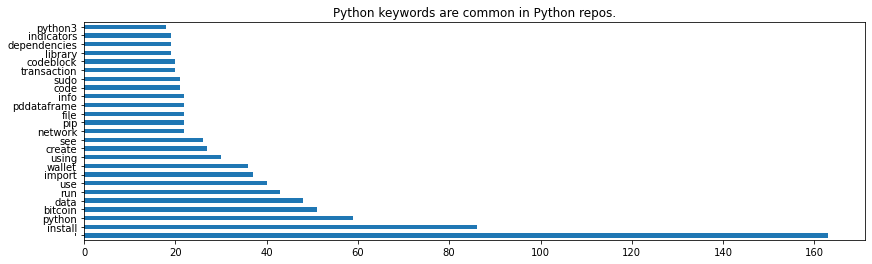

In [16]:
# Plot top 25 words

plt.figure(figsize = (14, 4))
python_clean_words_freq = pd.Series(python_clean_words.split())
python_clean_words_freq.value_counts().head(25).plot.barh()
plt.title('Python keywords are common in Python repos.');

**Takeaways:**
- Python keywords are often mentioned in Python repos, such as "python", "import", "pip", and "pddataframe".
- "install" is the most frequent word, could be in relation to "pip install".

In [17]:
# Now let's see word frequencies specifically for c++ repos.

c_plus_plus_clean_words = ' '.join(readme for readme in df[c_plus_plus].clean)

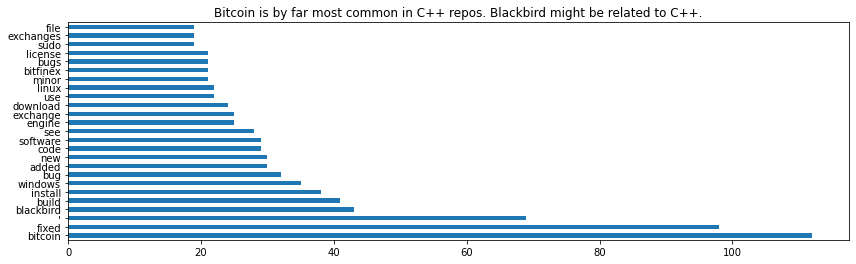

In [18]:
# Plot top 25 words

plt.figure(figsize = (14, 4))
c_plus_plus_clean_words_freq = pd.Series(c_plus_plus_clean_words.split())
c_plus_plus_clean_words_freq.value_counts().head(25).plot.barh()
plt.title('Bitcoin is by far most common in C++ repos. Blackbird might be related to C++.');

**Takeaways:**
- bitcoin is most common word followed by fixed.
- blackbird might help identify c++ repos.

In [19]:
# Now let's see word frequencies specifically for javascript repos.

javascript_clean_words = ' '.join(readme for readme in df[javascript].clean)

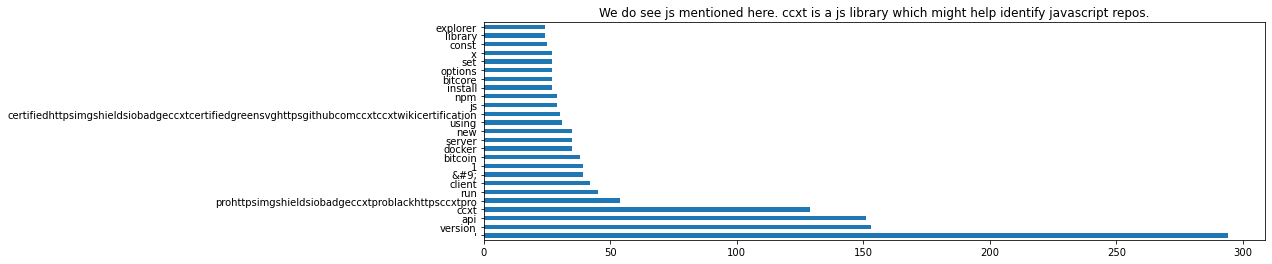

In [20]:
# Plot top 25 words

plt.figure(figsize = (14, 4))
javascript_clean_words_freq = pd.Series(javascript_clean_words.split())
javascript_clean_words_freq.value_counts().head(25).plot.barh()
plt.title('We do see js mentioned here. ccxt is a js library which might help identify javascript repos.');

**Takeaways:**
- There are some incredibly long strings here. Not sure if this is how they are in the READMEs or if it is a result of the preparation.
- js, docker, and ccxt are frequent words which could help specifically identify javascript repos

In [21]:
# Now let's see word frequencies specifically for other repos.

other_clean_words = ' '.join(readme for readme in df[other].clean)

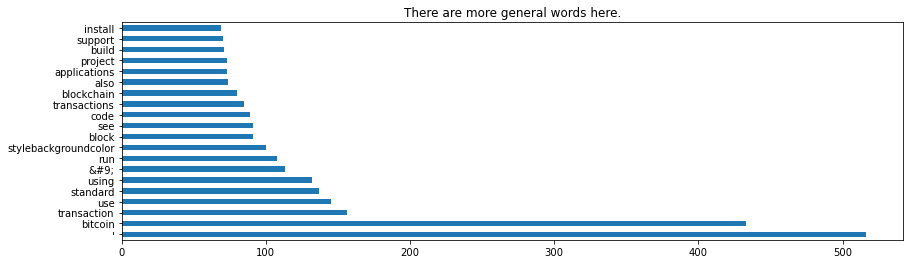

In [22]:
# Plot top 20 words

plt.figure(figsize = (14, 4))
other_clean_words_freq = pd.Series(other_clean_words.split())
other_clean_words_freq.value_counts().head(20).plot.barh()
plt.title('There are more general words here.');

**Takeaways:**
- We see a lot more general words here like "bitcoin", "transaction", "use", and "standard".
- Could possibly say that if a readme does not fit the other 3 classes than it is other.

#### Takeaways

There are certain keywords that could be indicative of a repo being primarily a specific language. These are keywords like "python", "pip", and "pddataframe" for Python repos, "blackbird" and possibly "windows" for C++ repos, and "js", "docker", and "ccxt" for JavaScript repos.

Additionally there are some words that are fairly frequent across all target classes such as "bitcoin" and "install" that could possibly be ignored since they don't provide much value to us.

### Does README size vary by programming language?

We want to know if the size of a README may vary depending on the primary programming language for the repo. We'll look at several metrics for determining the size of the README: character count, word count, and sentence count.

#### Character Count

In [23]:
# Create a character_count feature

df['character_count'] = df.clean.apply(len)
df.character_count.head()

0     2338
1     5074
2    20030
3    10992
4     3214
Name: character_count, dtype: int64

In [31]:
# Now let's see how the average character count varies by target class.

print(f'Python average character count: {df[python].character_count.mean()}')
print(f'C++ average character count: {df[c_plus_plus].character_count.mean()}')
print(f'JavaScript average character count: {df[javascript].character_count.mean()}')
print(f'Other average character count: {df[other].character_count.mean()}')

Python average character count: 2969.6111111111113
C++ average character count: 2643.705882352941
JavaScript average character count: 7670.5
Other average character count: 4631.509433962264


It looks like READMEs for JavaScript repos tend to be larger in size. Let's see if there is a statistically significant difference.

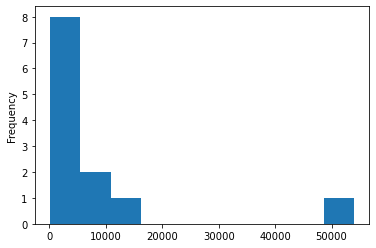

In [32]:
# We'll test the following hypothesis:
# H0: The average character count for READMEs in JavaScript repos is equal to the average 
# character count for all READMEs.
# Ha: The average character count for READMEs in JavaScript repos is greater than the average 
# character count for all READMEs.

# But first we'll need to determine if our sample is normally distributed.

df[javascript].character_count.plot.hist();

In [33]:
df[javascript].shape

(12, 10)

In [41]:
# We cannot make the assumption that the target is normally distributed.

alpha = 0.05

t, p = stats.ttest_1samp(df[javascript].character_count, df.character_count.mean(), alternative = 'greater')

if p < alpha:
    print('Fail to reject H0')
else:
    print('Reject H0')

Reject H0


We reject the null hypothesis meaning that for JavaScript repos the average character count of the README is significantly greater than the average character count for all READMEs. However, this should be taken with a grain of salt since we do not have a large number of javascript repos to test this hypothesis with.

#### Word Count

In [42]:
# Create a word_count feature

df['word_count'] = df.clean.apply(lambda text: len(text.split()))

In [43]:
df.word_count.head()

0     264
1     420
2    2124
3     834
4     337
Name: word_count, dtype: int64

In [44]:
# Now let's see how the average word count varies by target class.

print(f'Python average word count: {df[python].word_count.mean()}')
print(f'C++ average word count: {df[c_plus_plus].word_count.mean()}')
print(f'JavaScript average word count: {df[javascript].word_count.mean()}')
print(f'Other average word count: {df[other].word_count.mean()}')

Python average word count: 339.05555555555554
C++ average word count: 314.0
JavaScript average word count: 535.4166666666666
Other average word count: 457.47169811320754


This is similar to the results obtained for character count. We'll move on.

### N-grams vs. Target Variable

Now let's try creating bi-grams and tri-grams to see if this might provide better insights into what the target class might be for a given README.

In [50]:
# Let's generate some bi-grams for all READMEs and for each target class.

all_bigrams = pd.Series(nltk.bigrams(clean_words.split()))
all_bigrams.value_counts().head(20)

(api, version)                                                                                         131
(bitcoin, core)                                                                                         81
(', ')                                                                                                  58
(ccxt, prohttpsimgshieldsiobadgeccxtproblackhttpsccxtpro)                                               54
(stylebackgroundcolor, cfffcf)                                                                          43
(stylebackgroundcolor, ffcfcf)                                                                          42
(&#9;, &#9;)                                                                                            41
(final, stylebackgroundcolor)                                                                           36
(git, clone)                                                                                            36
(standard, final)                    

## Feature Engineering

In this section we will perform some feature engineering to create features that may be useful in the modeling phase of the pipeline.

### Identifying Keywords for Specific Target Classes

Here we will create a feature that determines if certain keywords common for a specific programming language are present in the README. The keywords we'll be looking for are the following:

- "python", "python3", "import", "pip", and "pddataframe" for Python repos.
- "windows", "linux", and "blackbird" for C++ repos.
- "js", "docker", "npm", and "ccxt" for JavaScript repos.

Any README that does not fit into one of these three categories will be classified as other.

In [25]:
# Let's start with the Python keywords. We want to know if finding one of the keywords is fairly indicative
# of the repo being a Python repo.

keywords = [
    'python',
    'import',
    'pip',
    'pddataframe',
    'python3'
]

df[python].clean.str.contains(r'(python)|(import)|(pip)|(pddataframe)|(python3)', regex = True).value_counts()

True     16
False     2
Name: clean, dtype: int64

It looks like most Python repos do have one of those keywords.

In [26]:
# Now let's try the C++ keywords. We want to know if finding one of the keywords is fairly indicative
# of the repo being a C++ repo.

keywords = [
    'windows',
    'linux',
    'blackbird'
]

df[c_plus_plus].clean.str.contains(r'(windows)|(linux)|(blackbird)', regex = True).value_counts()

True     9
False    8
Name: clean, dtype: int64

That's slightly helpful, but half of the repos do not have one of the keywords.

In [27]:
# Now let's try the JavaScript keywords. We want to know if finding one of the keywords is fairly indicative
# of the repo being a JavaScript repo.

keywords = [
    'js',
    'docker',
    'ccxt',
    'npm'
]

df[javascript].clean.str.contains(r'(js)|(docker)|(ccxt)|(npm)', regex = True).value_counts()

True     8
False    4
Name: clean, dtype: int64

Most of the repos do have one of these keywords.

In [28]:
# Now let's try creating this feature. It will be easier to create three separate features for this:
# 'contains_python_keywords', 'contains_cpp_keywords', and 'contains_js_keywords'

df['contains_python_keywords'] = df.clean.str.contains(r'(python)|(import)|(pip)|(pddataframe)|(python3)', regex = True).astype(int)
df['contains_cpp_keywords'] = df.clean.str.contains(r'(windows)|(linux)|(blackbird)', regex = True).astype(int)
df['contains_js_keywords'] = df.clean.str.contains(r'(js)|(docker)|(ccxt)|(npm)', regex = True).astype(int)

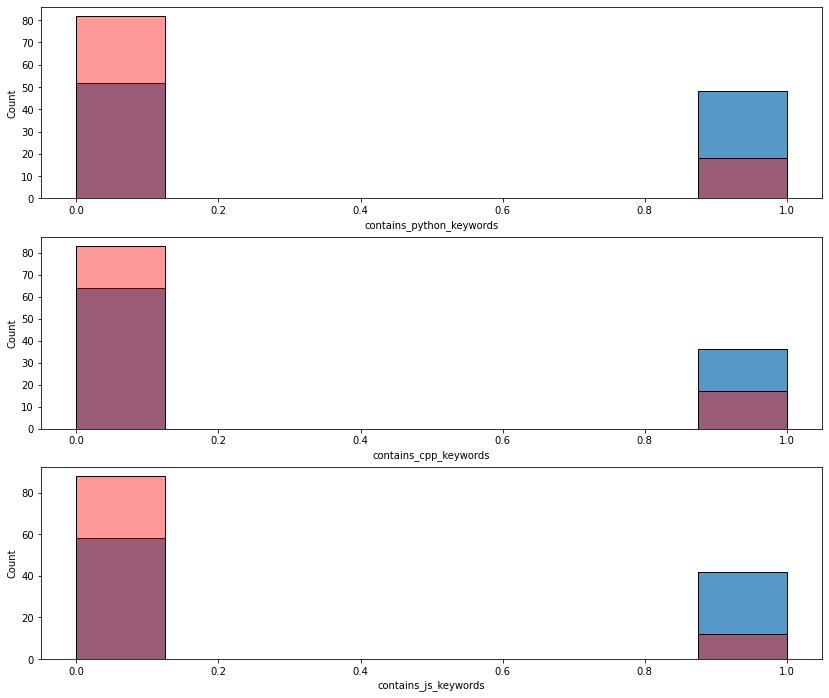

In [29]:
fig, ax = plt.subplots(ncols = 1, nrows = 3, figsize = (14, 12))

sns.histplot(data = df.contains_python_keywords, ax = ax[0])
sns.histplot(data = (df.language == 'Python').astype(int), alpha = 0.4, color = 'red', ax = ax[0])

sns.histplot(data = df.contains_cpp_keywords, ax = ax[1])
sns.histplot(data = (df.language == 'C++').astype(int), alpha = 0.4, color = 'red', ax = ax[1])

sns.histplot(data = df.contains_js_keywords, ax = ax[2])
sns.histplot(data = (df.language == 'JavaScript').astype(int), alpha = 0.4, color = 'red', ax = ax[2]);

These features do help to correctly identify the target for some repos, but they also seem to find keywords in repos where the primary programming language is something else.